<h1><center>Cookie Cats Mobile Games</center></h1>
<center>May 2024</center>
<center>Celine Ng</center>

<a id="0"></a> <br>
# Table of Contents

1. [Project Introduction](#1)     
    1. [Libraries Installation](#2) 
    1. [Data Retrieval](#3)
    1. [Data Cleaning](#4)
1. [EDA](#5) 
    1. [Separate by Gate Level](#6)
        1. [Summary](#7)
1. [Target Metrics](#8) 
1. [Calculations](#9)
    1. [Statistical Tests](#10)
        1. [Summary](#11)
    1. [Confidence Interval](#12)
    1. [Estimated Treatment Difference](#13)
    1. [Decision](#14)
1. [Improvements](#15)

<a id="1"></a> <br>
# 1. Notebook Preparation

### Goal

When a player installed the game Cookie Cats, the player would be randomly <br>
assigned to either gate_30 or gate_40. The dataset includes A/B test results
 of <br>
the game when the first gate in the game was moved from level 30 to 40. <br>
Apply A/B test to determine where should the Cookie Cats game locate its gate.

<a id="2"></a> <br>
## 1.1 Libraries Installation

In [2]:
%%capture
%pip install -r requirements.txt

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import scikit_posthocs as sp
from utils.plotting import *
from scipy.stats import chi2_contingency
from utils.statistics import *
from scipy.stats import norm

<a id="3"></a> <br>
## 1.2 Data Retrieval

In [4]:
cookiecats = pd.read_csv('dataset/cookie_cats.csv')

In [5]:
cookiecats

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
...,...,...,...,...,...
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False


**The variables are:** <br>
1. userid - A unique number that identifies each player <br>
2. version - Whether the player was put in the control group (gate_30 - a gate 
at <br>
 level 30) or the group with the moved gate (gate_40 - a gate at level 40) <br>
 3. sum_gamerounds - the number of game rounds played by the player during the 
 <br>
 first 14 days after install. <br>
 4. retention_1 - Did the player come back and play 1 day after installing? 
 <br>
 5. retention_7 - Did the player come back and play 7 days after installing?

<a id="4"></a> <br>
## 1.3 Data Cleaning

1. Check for missing values

In [6]:
cookiecats.isna().any().any()

False

2. Check for duplicates 

In [7]:
cookiecats.duplicated().any()

False

<a id="5"></a> <br>
# 2. EDA

1. Rows and columns of our dataset

In [8]:
cookiecats.shape

(90189, 5)

2. Dataset descriptive statistics overview

In [9]:
cookiecats.describe()

,userid,sum_gamerounds
count,9.018900e+04,90189.000000
mean,4.998412e+06,51.872457
std,2.883286e+06,195.050858
min,1.160000e+02,0.000000
25%,2.512230e+06,5.000000
50%,4.995815e+06,16.000000
75%,7.496452e+06,51.000000
max,9.999861e+06,49854.000000


3. Sample size for each gate

In [10]:
sample_size = cookiecats.version.value_counts()
sample_size

version
gate_40    45489
gate_30    44700
Name: count, dtype: int64

The sample sizes are similar.

4. Are userid repeated?

In [11]:
cookiecats.userid.nunique()

90189

No users were repeated.

<a id="6"></a> <br>
## 2.1 Separate by Gate Level

Objective: <br>
To better define our target metric and properly pick the correct statistical
 <br>
tests, it is essential to first understand the features, and their <br>
relationships with different gates.

**Sum Game Rounds**

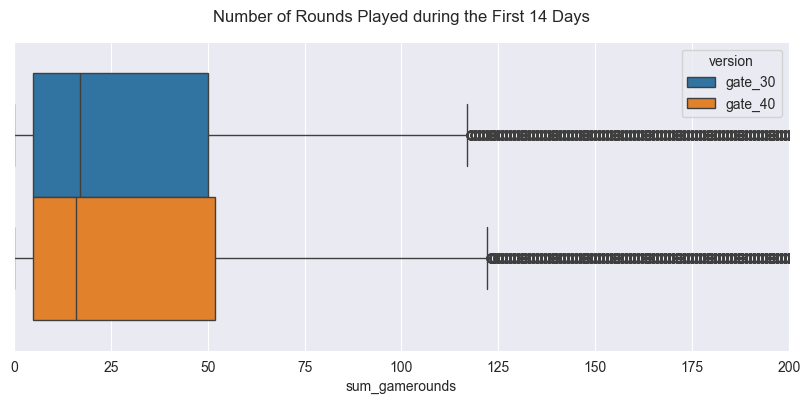

In [12]:
plt.figure(figsize=(10, 4))
sns.boxplot(data=cookiecats, x='sum_gamerounds', hue='version')
sns.despine(top=True, right=True, left=False, bottom=False)
plt.xlim(0, 200)
plt.xlabel('sum_gamerounds')
plt.title('Number of Rounds Played during the First 14 Days', pad=15)
plt.show()

In [13]:
cookiecats.groupby(['version']).describe()['sum_gamerounds']

,count,mean,std,min,25%,50%,75%,max
version,,,,,,,,
gate_30,44700.0,52.456264,256.716423,0.0,5.0,17.0,50.0,49854.0
gate_40,45489.0,51.298776,103.294416,0.0,5.0,16.0,52.0,2640.0


How many total sum game rounds did each have?

In [14]:
cookiecats.groupby(['version'])['sum_gamerounds'].sum()

version
gate_30    2344795
gate_40    2333530
Name: sum_gamerounds, dtype: int64

**Retention 1 and 7**

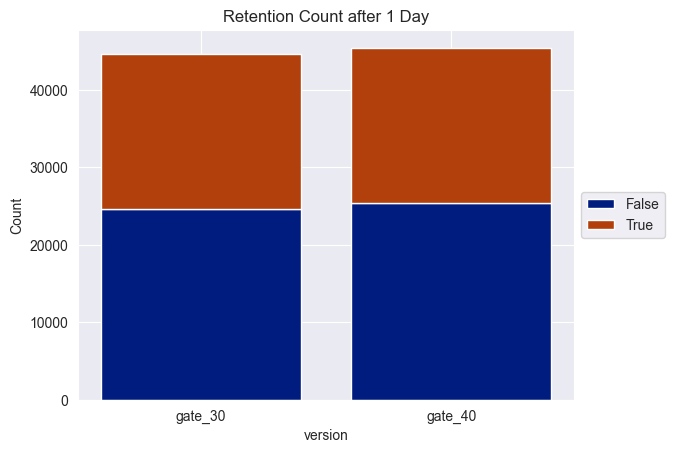

In [15]:
stacked_bar_plot(cookiecats, col='version', hue='retention_1', 
                 title='Retention Count after 1 Day')

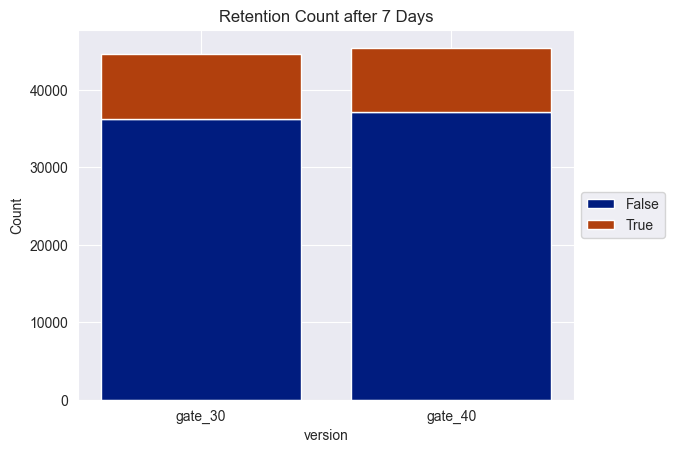

In [16]:
stacked_bar_plot(cookiecats, col='version', hue='retention_7', 
                 title='Retention Count after 7 Days')

Calculate Retention Rate

In [17]:
retention_rates = cookiecats.groupby('version').agg({
    'userid': 'count',
    'retention_1': 'mean',
    'retention_7': 'mean'
})
retention_rates['retention_1'] = retention_rates['retention_1'] * 100
retention_rates['retention_7'] = retention_rates['retention_7'] * 100

retention_rates.columns = ['userid', 'retention_1 (%)', 'retention_7 (%)']
retention_rates


,userid,retention_1 (%),retention_7 (%)
version,,,
gate_30,44700,44.818792,19.020134
gate_40,45489,44.228275,18.200004


<a id="7"></a> <br>
### 2.1.1 Summary

1. The average number of game rounds played, by the player during the first 
14 <br>
days after installation, was similar for both versions of the game. But the 
<br>
standard deviation for version gate_30 was almost double of version gate_40.
  <br>
2. For both versions, retentions rates on day 1 and 7 are similar, though the 
<br>
difference is larger after 7 days.

<a id="8"></a> <br>
# 3. Target Metric

Since 'sum_gamerounds' had similar means for both versions but the standard 
<br>
deviation was large, this feature is likely to not have enough sensitivity <br>
to give us clear results. <br>
 Instead, analyzing the retentions might be more powerful. <br>

**Target Metric**
Identify if version gate_30 indeed does have a higher 7 days retention rate.
 <br>
This metric indicates the lasting appeal of the game, as it is a longer term <br>
retention.

<a id="9"></a> <br>
# 4. Calculations

Objectives: <br>
1. Decide on the best suited statistical tests for our target metric.
2. Sanity check.
2. Conduct statistical tests.
3. Report confidence interval and p-value.

For this target metric, Chi Square test will be used as our data is <br>
categorical, and it will detect if the retention rate is different between <br>
the 2 versions. <br>
For all the statistical tests, the significance level we are interested in 
 <br>
 is 0.05.

<a id="10"></a> <br>
## 4.1 Statistical Test

### Chi Square Test

**Assumption Checking** <br>
1. Data consists of 2 categorical and independent variables
2. There are 2 groups within each variable


**Null Hypothesis (H0):**<br>
There is no difference in the 7 days retention rates between version gate_30
 and version gate_40. <br>

**Alternative Hypothesis (H1):**<br>
There is a difference in the 7 days retention rates between version gate_30
 and version gate_40. <br>

In [18]:
contingency_table = pd.crosstab(cookiecats['version'], 
                                cookiecats['retention_7'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-Square Statistic: {chi2}")
print(f"P-value: {p_value}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected)

Chi-Square Statistic: 9.959086799559167
P-value: 0.00160057426790583
Degrees of Freedom: 1
Expected Frequencies:
[[36382.90257127  8317.09742873]
 [37025.09742873  8463.90257127]]


<a id="11"></a> <br>
### 4.1.1 Summary

P-value is lower than our significance level (0.05), so the null hypothesis 
<br>
is rejected and there is a statistically significant difference between the 
<br>
2 versions of Cookie Cats. <br>
With previously calculated retention rate, it is clear that the version <br>
gate_30 has a higher retention rate than gate_40. 

<a id="12"></a> <br>
## 4.2 Confidence Interval
Objective: Determine confidence interval for our population proportions

In [19]:
cookiecats['retention_7'] = cookiecats['retention_7'].astype(int)
versions = ['gate_30', 'gate_40']
ci_results = [ci_bootstrap(data=cookiecats[cookiecats['version'] == 
                                            version]['retention_7']) for 
              version in versions]
ci_df_bootstrap = pd.DataFrame(ci_results, columns=['Mean', 'CI Lower', 'CI Upper'])
ci_df_bootstrap['Version'] = ['Gate 30', 'Gate 40']
ci_df_bootstrap = ci_df_bootstrap[['Version', 'Mean', 'CI Lower', 'CI Upper']]
ci_df_bootstrap

,Version,Mean,CI Lower,CI Upper
0,Gate 30,0.190190,0.186488,0.193714
1,Gate 40,0.182007,0.178504,0.185496


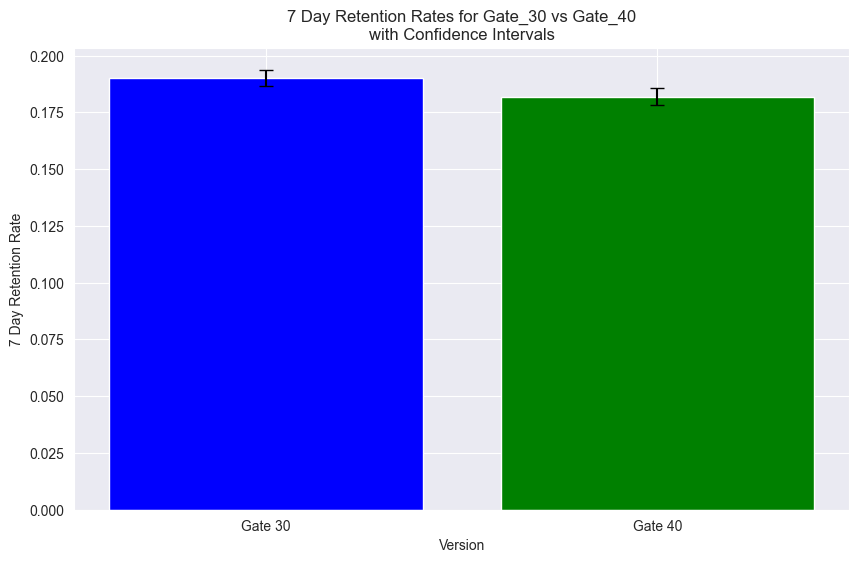

In [20]:
versions = ['Gate 30', 'Gate 40']
means = [0.190191, 0.181977]
ci_lowers = [0.186688, 0.178437]
ci_uppers = [0.193827, 0.185629]

errors = [[means[i] - ci_lowers[i] for i in range(len(means))],
          [ci_uppers[i] - means[i] for i in range(len(means))]]


fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(versions, means, yerr=errors, color=['blue', 'green'], capsize=5)
ax.set_xlabel('Version')
ax.set_ylabel('7 Day Retention Rate')
ax.set_title('7 Day Retention Rates for Gate_30 vs Gate_40\nwith Confidence '
             'Intervals')

plt.show()

<a id="13"></a> <br>
## 4.3 Estimated Treatment Difference
Objective: Estimate the difference between proportions with confidence

In [21]:
retention_rates

,userid,retention_1 (%),retention_7 (%)
version,,,
gate_30,44700,44.818792,19.020134
gate_40,45489,44.228275,18.200004


In [22]:
n1 = retention_rates.iloc[0, 0]
p1 = retention_rates.iloc[0, 2]/100
n2 = retention_rates.iloc[1, 0]
p2 = retention_rates.iloc[1, 2]/100

SE = np.sqrt((p1 * (1 - p1) / n1) + (p2 * (1 - p2) / n2))
z_score = norm.ppf(0.975)
margin_of_error = z_score * SE

ci_lower = (p1 - p2) - margin_of_error
ci_upper = (p1 - p2) + margin_of_error

print("Estimated difference in 7-day retention rates(Gate 30 - "
      "Gate 40):", p1 - p2)
print("95% Confidence Interval for the difference:", (ci_lower, 
                                                            ci_upper))

Estimated difference in 7-day retention rates(Gate 30 - Gate 40): 0.008201298315205913
95% Confidence Interval for the difference: (0.0031210442115262808, 0.013281552418885545)


In [23]:
z_score

1.959963984540054

<a id="14"></a> <br>
## 4.4 Decision

After calculating the confidence intervals, it is clear that the 7 day <br>
retention rates for the 2 versions of the game do not overlap, with a 95% <br>
confidence level. Also, with p-value under 0.05, we can safely conclude that
 <br>
 7 day retention is higher when the gate is located at level 30. 

<a id="15"></a> <br>
# 5. Improvements

1. Add another target metric, such as the difference between retention <br>
rates of day 1 and 7.
